## Exploration

train.csv shape is  (1697533, 6)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4   
1   354887  6303079709  A2I8RXJN80A2D2   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY   
4   475323  630574453X  A13NM1PES9OXVN   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with you   

                                                Text  Score  
0  While most straight to DVD films are not worth...    5.0  
1  I have wanted this one for sometime, also.  I ...    5.0  
2  Actually this was a pretty darn good indie fil...    4.0  
3  Episodes 37 to 72 of the series press on in a ...    5.0  
4  I was really impressed with this movie, but wa...    3.0

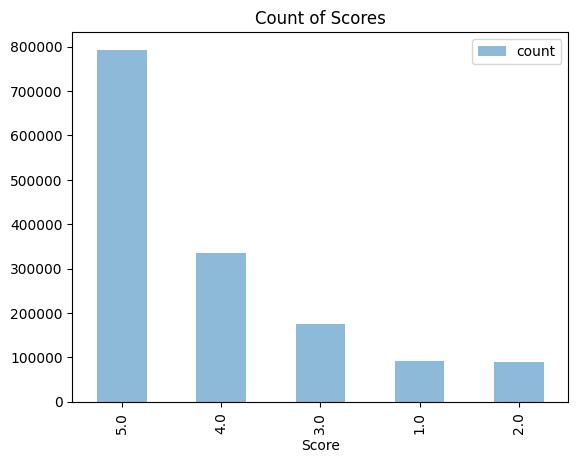

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

In [2]:
train_clean = trainingSet.dropna(subset=['Score']).copy()

# Convert Score to integer
train_clean['Score'] = train_clean['Score'].astype(int)
valid_scores = train_clean['Score'].between(1, 5)
train_sample = train_clean[valid_scores]


def combine_text(summary, text):
    return (summary.fillna('') + " " + text.fillna('')).str.strip()

# Combine Summary + Text into a single field
def preprocess_data(df):
    df = df.copy()
    df['combined_text'] = combine_text(df['Summary'], df['Text'])
    return df

train_sample = preprocess_data(train_sample)

# Get rows from train.csv that match the test Ids
test_rows = trainingSet[trainingSet['Id'].isin(testingSet['Id'])].copy()
test_rows = preprocess_data(test_rows)

## Feature Extraction

## Creating your model

In [3]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        train_sample['combined_text'],
        train_sample['Score'],
        test_size=1/4.0,
        random_state=0
    )

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(    
    ngram_range = (1, 3),
    max_features=8000,       
    min_df=5,                
    max_df=0.75,
    stop_words='english',     
    sublinear_tf=True 
    )

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
model = DecisionTreeClassifier(
    # class_weight='balanced',
    max_depth = 20,          
    min_samples_split = 10,  
    random_state = 42,
)


model.fit(X_train_tfidf, Y_train)



Y_test_pred = model.predict(X_test_tfidf)
print("Accuracy on test set:", accuracy_score(Y_test, Y_test_pred))

#Save the Model
with open('decision_tree_model.pkl', 'wb') as f:
    pickle.dump(model, f)
# pickle model - saves it so you can load it later
#with open('knn_20_model.obj', 'wb') as f:
#        pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluation

Accuracy on training set =  0.5492345186960561
Accuracy on testing set =  0.5459045177413447


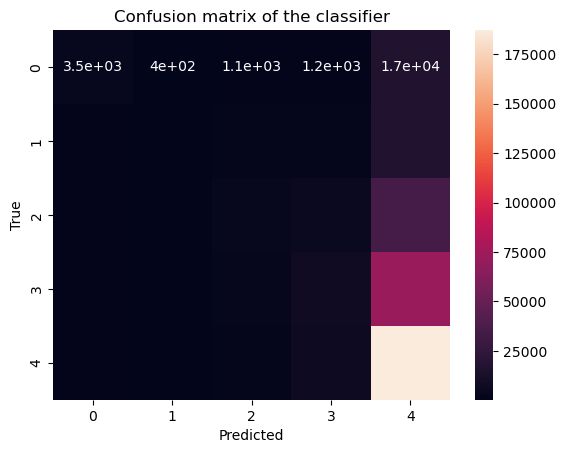

In [61]:
Y_train_pred = model.predict(X_train_tfidf)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = model.predict(X_test_tfidf)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [62]:
test_predictions = model.predict(vectorizer.transform(test_rows['combined_text']))

submission = pd.DataFrame({
    'Id': test_rows['Id'],
    'Score': test_predictions
})
submission.to_csv('submission.csv', index=False)

Now you can upload the `submission.csv` to kaggle